---


# <center> $\text{Deep Learning in Medical Imaging - MVA 2021/2022}$
<br>

### <center> $\text{Siwar Mhadhbi}$  $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $\text{Eya Ghamgui}$
### <center> siwar.mhadhbi@telecom-paris.fr $~~~~~~~$ eya.ghamgui@telecom-paris.fr

#### <center>  $\text{April} ~10^{th}$, $2022$




---


## Problem context

An important component of cancer staging is the grade of cancer. Traditionally, the grades of prostate cancer were described according to the Gleason score. In the 1960s, Dr. Donald Gleason realized that cancer cells fall into five distinct categories as they progress from normal cells to tumor cells. The cells are graded on a scale of 1 to 5.  Grade 1 cells look like normal prostate tissue. Cells closest to 5 are considered "high grade" and have undergone many mutations. Over decades, the Gleason system has been widely used in clinical practice and research, and many organizations have adopted it as the global standard for classifying prostate cancer. In 2005, the International Society of Urological Pathology (ISUP) held a consensus conference to discuss and review the Gleason grade. They resulted in a new ISUP grade that summarizes the severity of prostate cancer. <br> 

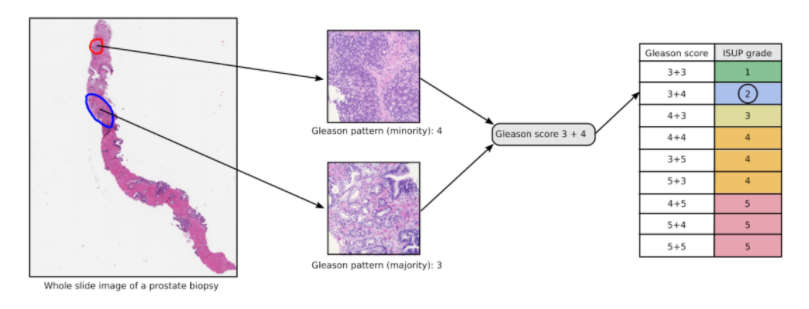

$\implies$ The goal of this challenge is to assign ISUP grades to histopathologic images of prostate cancer. 

<font  color='red'> **NB. <br> In order to recreate the pre-processed images for this notebook, you can uncomment the commented cells. Otherwise, we have provided a link to a drive that contains all the data used for this notebook. You can just change the "Working_dir" variable to the directory that contains the data.**

https://drive.google.com/drive/folders/1GZ8cKy2oUIlJoEvtRpXXaTnHVNbhy2J4?usp=sharing

## Setup & Importations

In [ ]:
# Cell to mount google drive to access data
"""
from google.colab import drive
drive.mount('/content/drive')
"""

In [ ]:
!apt update && apt install -y openslide-tools
!pip install openslide-python
!pip install tifffile
!pip install timm
!pip install spams

In [ ]:
# Import functions from .py files

from resnet18 import ResNet18
from test import test, test_MIL
from MIL_resnet18 import MIL_resnet18
from pooling_resnet18 import pooling_ResNet18
from concatenate_tiles import concatenate_tiles
from create_tiles import create_tiles, create_tiles_no_mask
from train import train, train_augmented, train_MIL, train_MIL_augmented
from utils import wsi_info, show_masks, overlay_mask_on_slide, before_after_mask, Loss, show
from utils import read_data, read_data_augmented, read_unlabeled_data, read_test_data, read_test_data_MIL, read_data_MIL

In [ ]:
# Import useful packages 

import os

import cv2
import PIL
import tifffile
import openslide
import skimage.io
from PIL import Image
import stainNorm_Vahadane
from tifffile import imsave

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import timm
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam,SGD
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from fastai.vision import AdaptiveConcatPool2d, Flatten
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

## Load data

In [ ]:
# Path to working directory
working_dir = '/content/drive/MyDrive/DLMI/DLMI_Mhadhbi_Ghamgui/'  ## TO MODIFY

# Path to train data
path_train_data = working_dir + 'train.csv'
path_train_images = working_dir + 'train/train/'
path_label_masks = working_dir + 'train_label_masks/train_label_masks/'

# Path to test data
path_test_data = working_dir + 'test.csv'
path_test_images = working_dir + 'test/test/'

# Load train & test data
train_df = pd.read_csv(path_train_data)
test_df = pd.read_csv(path_test_data)

# Display train csv 
print("Train samples : ", len(train_df.image_id))
print("Test samples  : ", len(test_df.image_id))
print("Unique isup_grade (labels): ", train_df.isup_grade.unique())
print("Unique gleason_score : ", train_df.gleason_score.unique(), end='\n\n')
train_df['gleason_score'] = train_df['gleason_score'].apply(lambda x: '0+0' if x=='negative' else x)
train_df = train_df.set_index('image_id')

train_df.head()

Train samples :  340
Test samples  :  86
Unique isup_grade (labels):  [0 4 1 3 2 5]
Unique gleason_score :  ['negative' '4+4' '3+3' '4+3' '3+4' '5+4' '0+0' '4+5' '3+5' '5+3' '5+5']



,data_provider,isup_grade,gleason_score
image_id,,,
995df9b93db1e396b57692c6c7f1d673,radboud,0,0+0
86d4621be3deca4f8d461e3abce7d585,radboud,4,4+4
e2578d331ae6cb3bc649027498c8ff8d,radboud,1,3+3
c65fcde885b4f231d03cefb0fc75f4fa,radboud,4,4+4
c4bbe05f5d77f1a42bc95191285ab1bb,radboud,3,4+3


## Data visualization

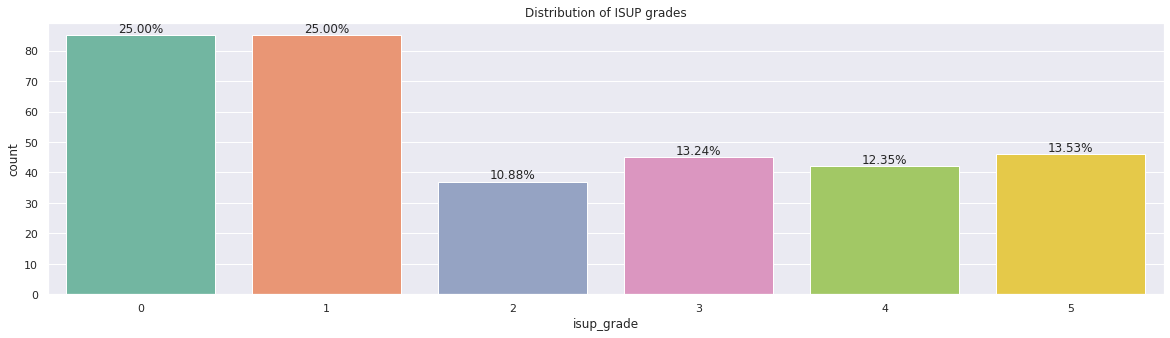

In [ ]:
# Distribution of ISUP grades
plt.figure(figsize=(20,5))
plt.title('Distribution of ISUP grades')
ax = sns.countplot(x='isup_grade', data=train_df, palette='Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height +1, '{:1.2f}%'.format(100*height/len(train_df.index)), ha="center")

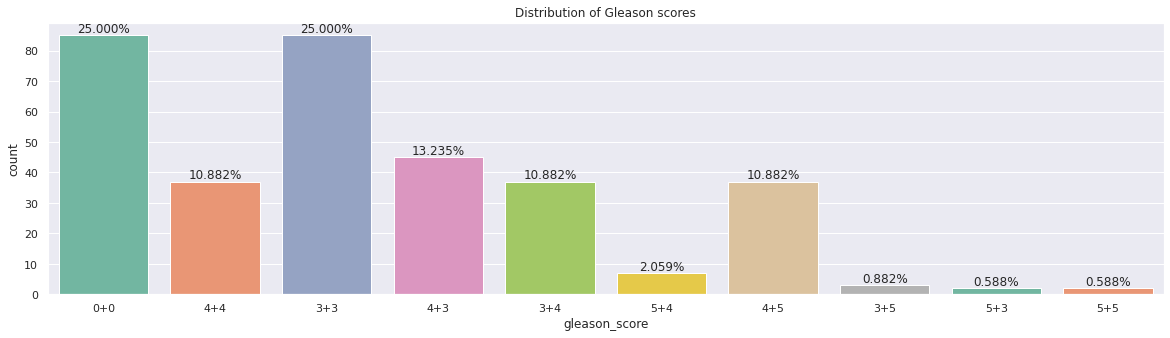

In [ ]:
# Distribution of Gleason scores
plt.figure(figsize=(20,5))
plt.title('Distribution of Gleason scores')
ax = sns.countplot(x='gleason_score', data=train_df, palette='Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height +1, '{:1.3f}%'.format(100*height/len(train_df.index)), ha="center")

File id: 001c62abd11fa4b57bf7a6c603a11bb9
Dimensions: (23904, 28664)
Microns per pixel / pixel spacing: 0.503
Downsample factor per level: (1.0, 4.0, 16.00223338916806)
Dimensions of levels: ((23904, 28664), (5976, 7166), (1494, 1791))

Gleason score: 4+4
ISUP grade: 4


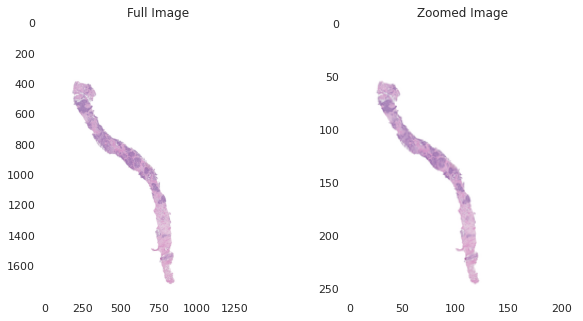

In [ ]:
# Display example wsi informations
example_id = '001c62abd11fa4b57bf7a6c603a11bb9'
wsi_info(train_df, path_train_images, example_id)

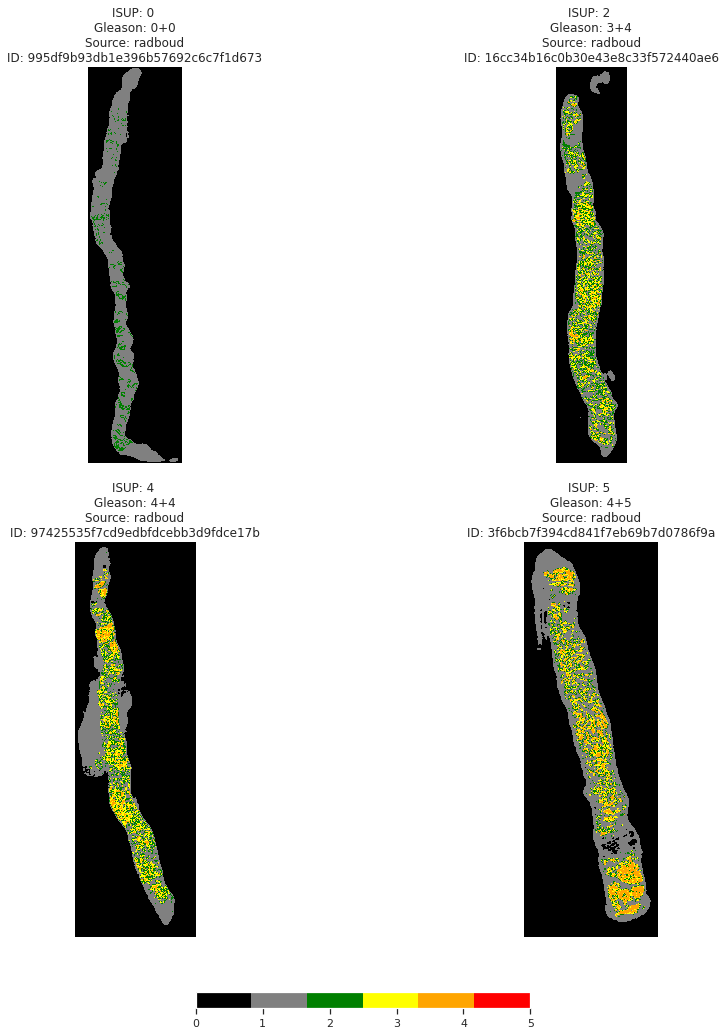

In [ ]:
# Show examples masks
list_mask = ['3f6bcb7f394cd841f7eb69b7d0786f9a','995df9b93db1e396b57692c6c7f1d673',
             '16cc34b16c0b30e43e8c33f572440ae6' , '97425535f7cd9edbfdcebb3d9fdce17b']
             
show_masks(train_df, path_label_masks, list_mask)

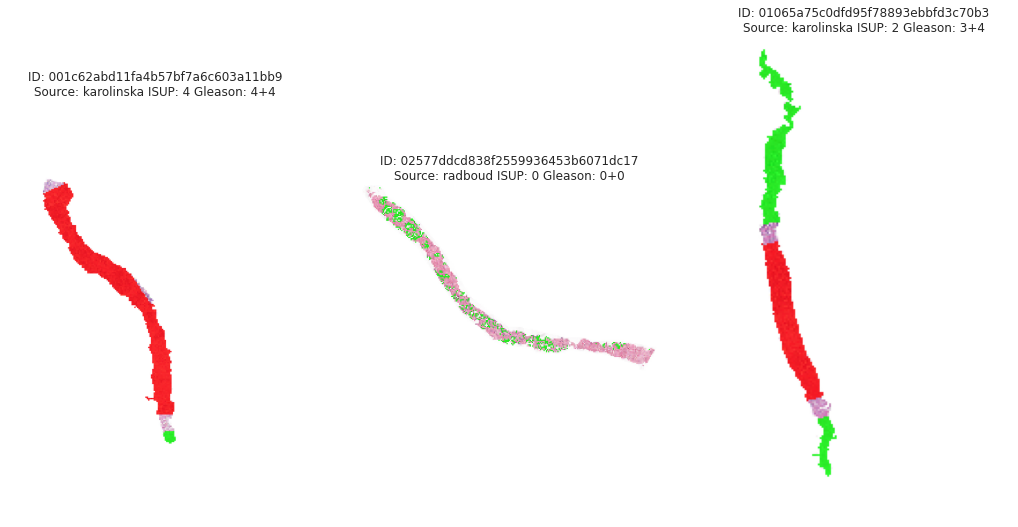

In [ ]:
# Overlay masks on slides
l = []
for i,im in enumerate(os.listdir(path_label_masks)):
  if i in [0,1,3] :
    l.append(im)
overlay_mask_on_slide(train_df, path_train_images, path_label_masks, l)

In [ ]:
# Id images with no masks
print('Id images with no masks:\n')
print(set(os.listdir(path_train_images))-set(os.listdir(path_label_masks)))

Id images with no masks:

{'f12da90682826a7b149fc550722e14c4.tiff', '3ae66332c2dd50c6ce458937d49f8232.tiff'}


## From WSI to Tiles

In [ ]:
# Create train tiles
"""
# Define stain normalizer
n = stainNorm_Vahadane.Normalizer()
n = create_tiles(path_train_images, path_to_save=working_dir+'train_clean_normalized/', n=n, path_label_masks=path_label_masks)
concatenate_tiles(working_dir+'train_clean_normalized/', path_to_save=working_dir+'train_clean_n_concatenated/')
"""

In [ ]:
# Create tiles for data without masks
"""
wsi_no_mask = ['f12da90682826a7b149fc550722e14c4', '3ae66332c2dd50c6ce458937d49f8232']
create_tiles_no_mask(wsi_no_mask,path_train_images, working_dir+'train_clean_normalized/', n)
concatenate_tiles(wsi_no_mask, path_to_save=working_dir+'train_clean_n_concatenated/', path=working_dir+'train_clean_normalized/',no_mask=True)
"""

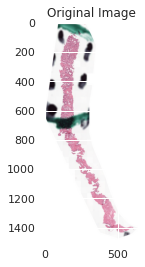

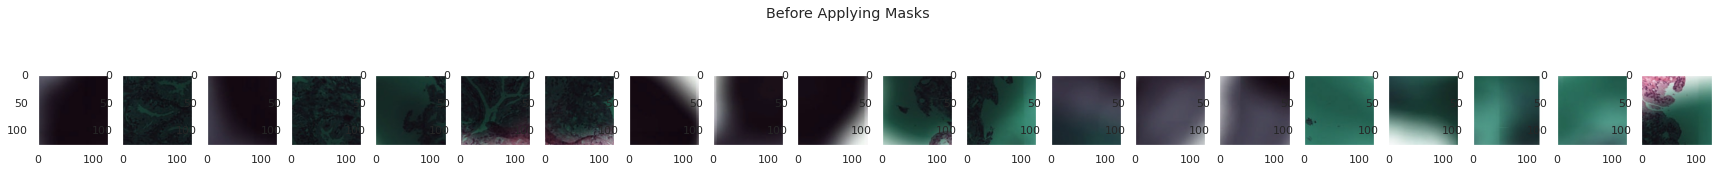

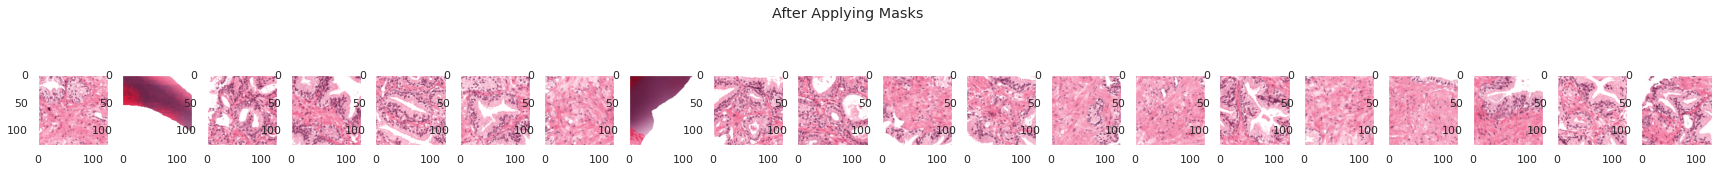

In [ ]:
# Compare tiles before and after applying mask
before_after_mask(path_train_images, working_dir, name='4a3e6e77b42a7e8f8b2dec472667bdbe')

## Modeling

In [ ]:
# Hyperparameters settings
epochs = 10
batch_size = 17

### First Approach: ResNet18

In [ ]:
# Read concatenated tiles 
X_train, X_val, y_train, y_val = read_data(working_dir, train_df)

train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train))
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val))
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/340 [00:00<?, ?it/s]

Train Epoch    Training loss    Training AUC    Training Acc    Validation AUC    Validation Acc
-----------    -------------    ------------    ------------    --------------    ---------------
     1             1.7433          0.6605          0.2146           0.7620            0.2655
     2             1.3943          0.8432          0.3868           0.8304            0.3500
     3             1.1655          0.8742          0.4818           0.7608            0.2448
     4             0.8543          0.9674          0.6336           0.7710            0.2759
     5             0.5346          0.9910          0.7829           0.7586            0.2819
     6             0.1920          1.0000          0.9663           0.7524            0.3911
     7             0.1108          1.0000          0.9944           0.7917            0.4142
     8             0.0478          1.0000          1.0000           0.7842            0.4385
     9             0.0284          1.0000          1.0000    

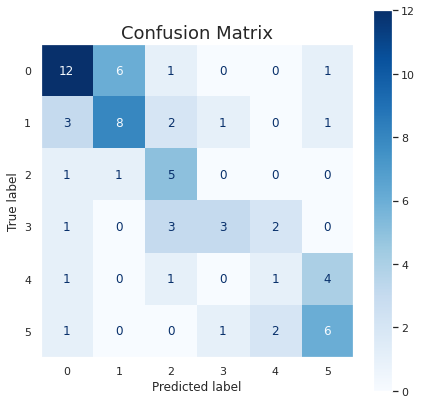

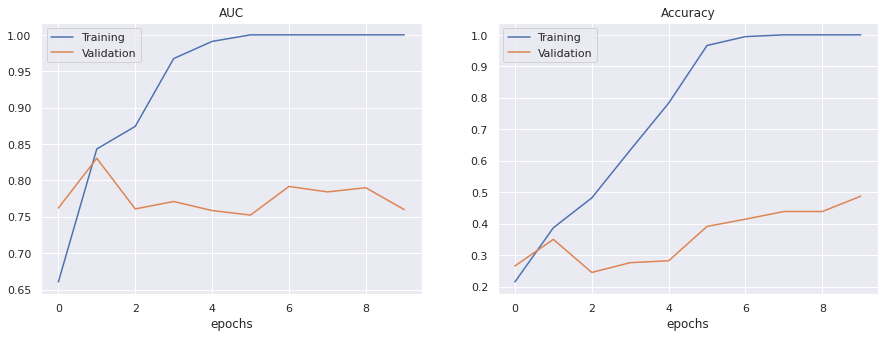

In [ ]:
# Apply ResNet18 without data augmentation
model = ResNet18() 

# Define CrossEntropy loss function
criterion = torch.nn.CrossEntropyLoss()

# Define SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.8)

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train(model, epochs, optimizer, criterion, train_loader, val_loader)

# Show training evolution 
show(train_auc, val_auc, train_acc, val_acc)

Train Epoch    Training loss    Training AUC    Training Acc    Validation AUC    Validation Acc
-----------    -------------    ------------    ------------    --------------    ---------------
     1             1.7822          0.5457          0.1970           0.6491            0.2108
     2             1.4398          0.7927          0.3707           0.7783            0.2695
     3             1.3009          0.8736          0.4013           0.7958            0.3733
     4             1.2601          0.8326          0.4814           0.8114            0.2841
     5             1.1337          0.8765          0.5275           0.8801            0.5972
     6             1.0187          0.8909          0.5738           0.8591            0.3501
     7             0.9464          0.9209          0.5678           0.8740            0.5368
     8             0.9547          0.9355          0.5658           0.8784            0.4430
     9             0.7527          0.9478          0.6701    

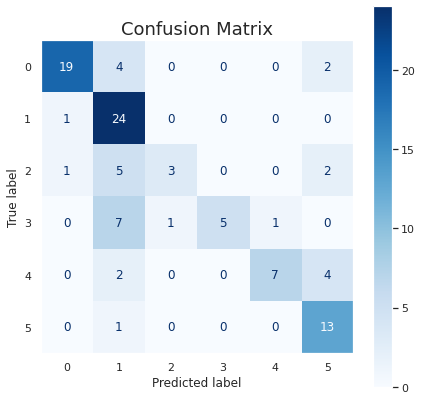

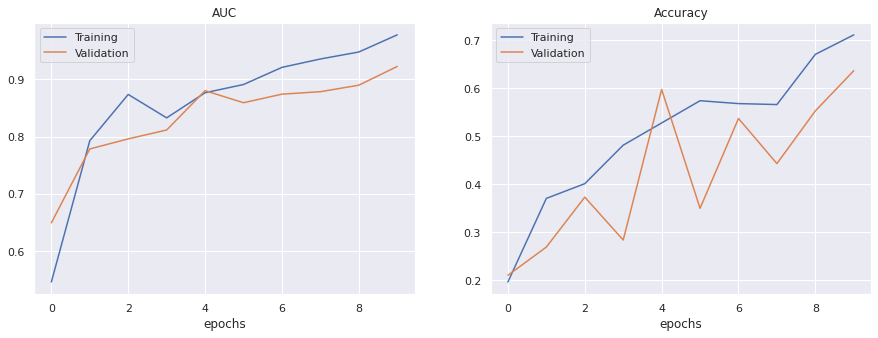

In [ ]:
# Apply ResNet18 with data augmentation
model = ResNet18() 

# Define CrossEntropy loss function
criterion = torch.nn.CrossEntropyLoss()

# Define SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.8)

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train_augmented(working_dir, train_df,model,epochs,optimizer, criterion,  batch_size = 17)

# Show training evolution 
show(train_auc, val_auc, train_acc, val_acc)

##### Training on whole dataset for submission

In [ ]:
# Read concatenated tiles 
X, y = read_data(working_dir, train_df, split=False)
train_tiles = TensorDataset(torch.tensor(X).float(), torch.tensor(y))
train_loader_tiles = DataLoader(dataset=train_tiles, batch_size=batch_size, shuffle=True)

  0%|          | 0/340 [00:00<?, ?it/s]

Train Epoch    Training loss    Training AUC    Training Acc
-----------    -------------    ------------    ------------
     1             1.7011          0.6483          0.2080
     2             1.3422          0.8242          0.4098
     3             1.1192          0.9055          0.5161
     4             0.8408          0.9659          0.6448
     5             0.4177          0.9965          0.8260
     6             0.1727          0.9997          0.9622
     7             0.0837          1.0000          0.9980
     8             0.0850          1.0000          0.9799
     9             0.1086          1.0000          0.9736
    10             0.0403          1.0000          1.0000


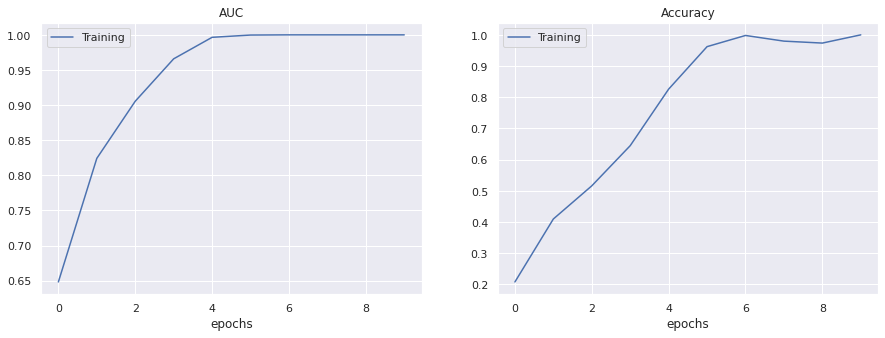

In [ ]:
# Apply ResNet18 without data augmentation on whole data
model = ResNet18() 

# Define CrossEntropy loss function
criterion = torch.nn.CrossEntropyLoss()

# Define SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.8)

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train(model, epochs, optimizer, criterion,train_loader_tiles, val=False)

# Show training evolution 
show(train_auc, val_auc, train_acc, val_acc)

Train Epoch    Training loss    Training AUC    Training Acc
-----------    -------------    ------------    ------------
     1             1.6944          0.6662          0.2418
     2             1.3910          0.8178          0.3972
     3             1.2345          0.8580          0.4806
     4             1.0825          0.8882          0.5349
     5             0.9936          0.9101          0.6130
     6             0.9247          0.9319          0.6260
     7             0.8243          0.9483          0.6653
     8             0.5796          0.9774          0.7757
     9             0.6606          0.9773          0.7250
    10             0.5689          0.9720          0.7891


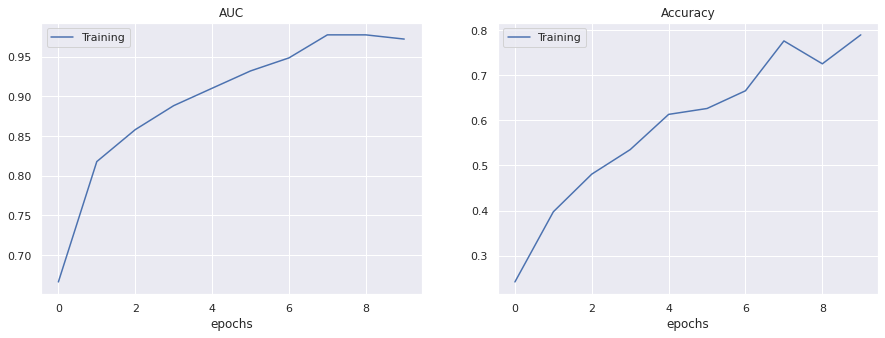

In [ ]:
# Apply ResNet18 with data augmentation on whole data
model = ResNet18() 

# Define CrossEntropy loss function
criterion = torch.nn.CrossEntropyLoss()

# Define SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.8)

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train_augmented(working_dir, train_df, model,epochs,optimizer, criterion, val=False)

# Training phase 
show(train_auc, val_auc, train_acc, val_acc)

### Second Approach: Pooling ResNet18

Train Epoch    Training loss    Training AUC    Training Acc    Validation AUC    Validation Acc
-----------    -------------    ------------    ------------    --------------    ---------------
     1             1.9652          0.5300          0.1678           0.5683            0.1792
     2             1.8196          0.6308          0.2332           0.6600            0.2393
     3             1.7128          0.6612          0.2691           0.6934            0.3159
     4             1.5693          0.7502          0.3522           0.6708            0.3165
     5             1.4431          0.7854          0.4253           0.6877            0.3165
     6             1.4380          0.7746          0.4145           0.6818            0.3001
     7             1.3437          0.8378          0.5031           0.6771            0.3394
     8             1.2350          0.8531          0.5354           0.6867            0.3239
     9             1.2584          0.8515          0.5267    

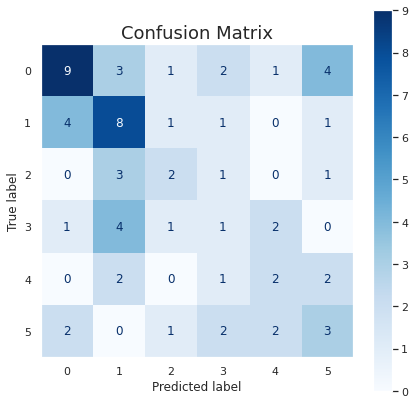

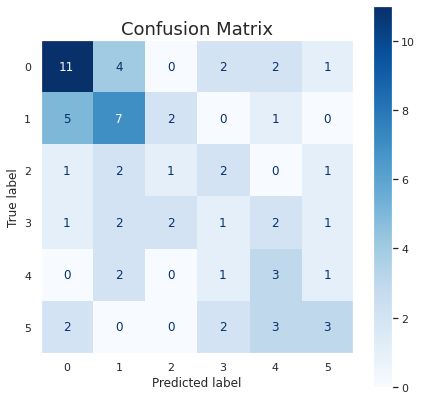

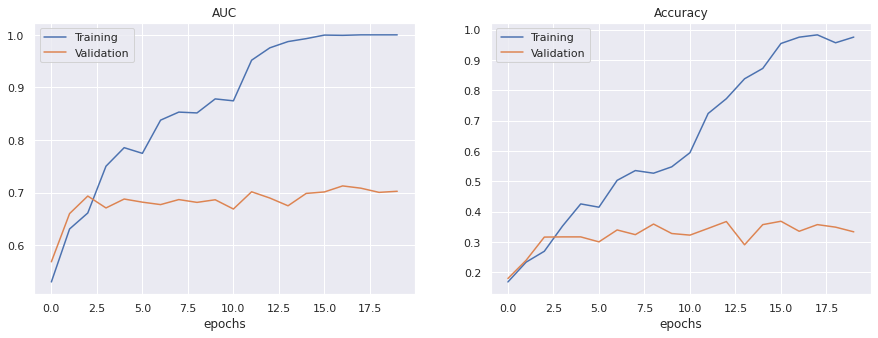

In [ ]:
# Apply Pooling ResNet18 without data augmentation
model = pooling_ResNet18() 

# Define CrossEntropy loss function
criterion = torch.nn.CrossEntropyLoss()

# Define SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# ------------------ Fine-tune only the head block parameters ------------------ #

for param in model.parameters():
  param.requires_grad = False

for param in model.head.parameters():
  param.requires_grad = True

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train(model,epochs,optimizer, criterion,train_loader, val_loader, start_epoch=0)

# ------------------------ Fine-tune all parameters ---------------------------- #

for param in model.parameters():
  param.requires_grad = True

# Training phase 
train_auc1 , training_loss1 , train_acc1 , val_auc1 , val_acc1 = train(model,epochs,optimizer, criterion, train_loader, val_loader, start_epoch=epochs)

# Show training evolution 
show(train_auc+train_auc1, val_auc+val_auc1, train_acc+train_acc1, val_acc+val_acc1)

Train Epoch    Training loss    Training AUC    Training Acc    Validation AUC    Validation Acc
-----------    -------------    ------------    ------------    --------------    ---------------
     1             2.0179          0.5145          0.1789           0.5562            0.1912
     2             1.9479          0.5281          0.2012           0.5587            0.2352
     3             1.7757          0.6243          0.2603           0.6652            0.3100
     4             1.7198          0.6725          0.2969           0.6082            0.3174
     5             1.6526          0.6903          0.3133           0.7318            0.4194
     6             1.6399          0.6739          0.3214           0.7796            0.3923
     7             1.4977          0.7558          0.4065           0.7727            0.4212
     8             1.5875          0.7239          0.4266           0.8443            0.5305
     9             1.4519          0.7418          0.4403    

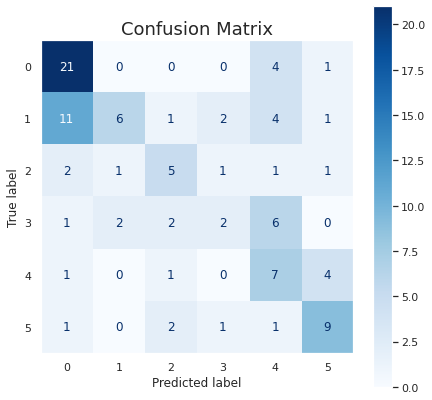

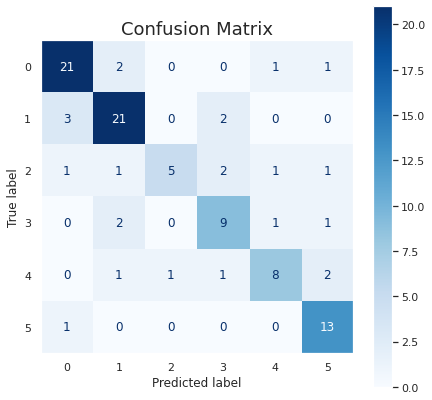

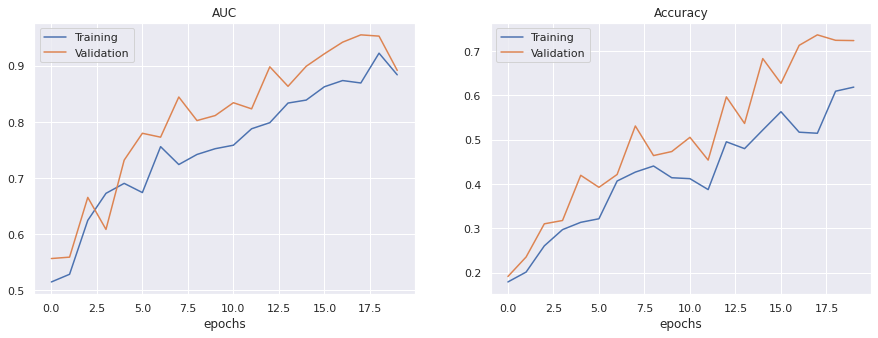

In [ ]:
# Apply Pooling ResNet18 with data augmentation
model = pooling_ResNet18() 

# Define CrossEntropy loss function
criterion = torch.nn.CrossEntropyLoss()

# Define SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# ------------------ Fine-tune only the head block parameters ------------------ #

for param in model.parameters():
  param.requires_grad = False

for param in model.head.parameters():
  param.requires_grad = True

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train_augmented(working_dir, train_df, model,epochs,optimizer, criterion, start_epoch=0,batch_size=batch_size)

# -------------------------- Fine-tune all parameters ----------------------------- #

for param in model.parameters():
  param.requires_grad = True

# Training phase 
train_auc1 , training_loss1 , train_acc1 , val_auc1 , val_acc1 = train_augmented(working_dir, train_df, model,epochs,optimizer, criterion, start_epoch=epochs,batch_size=batch_size)

# Show training evolution 
show(train_auc+train_auc1, val_auc+val_auc1, train_acc+train_acc1, val_acc+val_acc1)

##### Training on whole dataset for submission

Train Epoch    Training loss    Training AUC    Training Acc
-----------    -------------    ------------    ------------
     1             1.9471          0.5379          0.1890
     2             1.7851          0.6241          0.3069
     3             1.6820          0.6842          0.2819
     4             1.5343          0.7452          0.3792
     5             1.4509          0.7994          0.3732
     6             1.3488          0.8150          0.4619
     7             1.3125          0.8406          0.4900
     8             1.2658          0.8254          0.5255
     9             1.1906          0.8640          0.5449
    10             1.1353          0.8943          0.5680
    11             1.1339          0.8869          0.5743
    12             0.9831          0.9321          0.6708
    13             0.7383          0.9687          0.7864
    14             0.6420          0.9820          0.8454
    15             0.5315          0.9971          0.9034
    16  

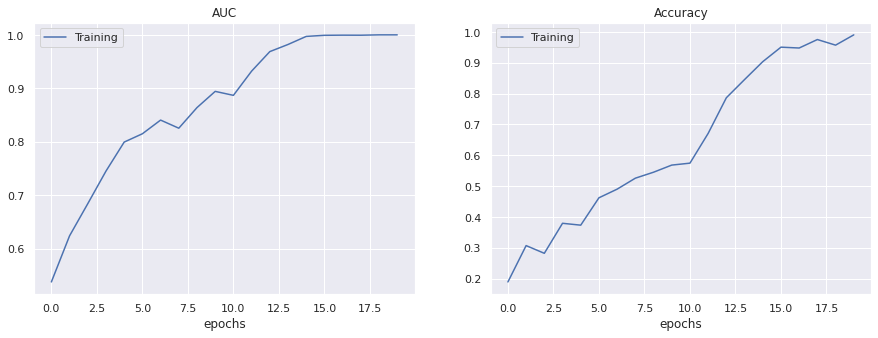

In [ ]:
# Apply Pooling ResNet18 without data augmentation on whole data
model = pooling_ResNet18() 

# Define CrossEntropy loss function
criterion = torch.nn.CrossEntropyLoss()

# Define SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# ------------------ Fine-tune only the head block parameters ------------------ #

for param in model.parameters():
  param.requires_grad = False

for param in model.head.parameters():
  param.requires_grad = True

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train(model,epochs,optimizer, criterion, train_loader_tiles, start_epoch=0, val=False)

# -------------------------- Fine-tune all parameters ----------------------------- #

for param in model.parameters():
  param.requires_grad = True

# Training phase 
train_auc1 , training_loss1 , train_acc1 , val_auc1 , val_acc1 = train(model,epochs,optimizer, criterion, train_loader_tiles, start_epoch=epochs, val=False)

# Show training evolution 
show(train_auc+train_auc1, val_auc+val_auc1, train_acc+train_acc1, val_acc+val_acc1)

Train Epoch    Training loss    Training AUC    Training Acc
-----------    -------------    ------------    ------------
     1             1.9122          0.5874          0.1978
     2             1.7918          0.5970          0.2454
     3             1.7066          0.6787          0.2595
     4             1.6412          0.6853          0.3252
     5             1.6093          0.7314          0.3351
     6             1.5159          0.7653          0.3781
     7             1.5266          0.7322          0.3558
     8             1.4816          0.7676          0.3629
     9             1.4167          0.7833          0.4070
    10             1.3866          0.7960          0.4583
    11             1.3202          0.8236          0.4709
    12             1.3129          0.8126          0.4524
    13             1.2066          0.8346          0.5124
    14             1.1255          0.8620          0.5006
    15             1.1024          0.8904          0.5733
    16  

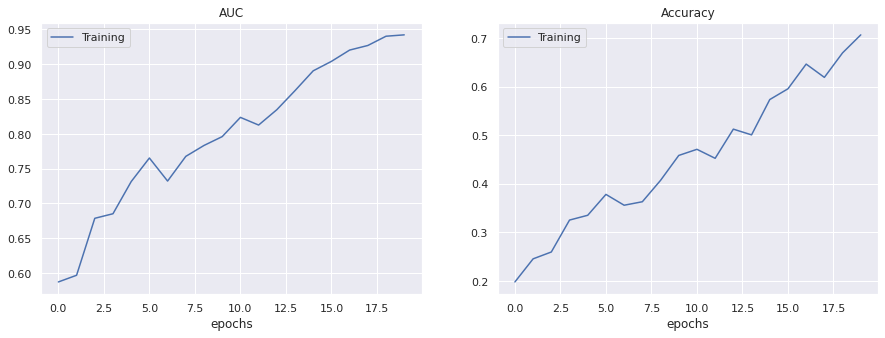

In [ ]:
# Apply Pooling ResNet18 with data augmentation on whole data
model = pooling_ResNet18() 

# Define CrossEntropy loss function
criterion = torch.nn.CrossEntropyLoss()

# Define SGD optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# ------------------ Fine-tune only the head block parameters ------------------ #

for param in model.parameters():
  param.requires_grad = False

for param in model.head.parameters():
  param.requires_grad = True

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train_augmented(working_dir, train_df, model,epochs,optimizer, criterion, start_epoch=0,batch_size=batch_size,val=False)

# -------------------------- Fine-tune all parameters ----------------------------- #

for param in model.parameters():
  param.requires_grad = True

# Training phase 
train_auc1 , training_loss1 , train_acc1 , val_auc1 , val_acc1 = train_augmented(working_dir, train_df, model,epochs,optimizer, criterion, start_epoch=epochs,batch_size=batch_size,val=False)

# Show training evolution 
show(train_auc+train_auc1, val_auc+val_auc1, train_acc+train_acc1, val_acc+val_acc1)

#### Semi-supervised Pooling ResNet18

In [ ]:
# Create tiles for unlabled data for the semi-supervised task 
"""
_ = create_tiles(path_images=working_dir+'Unlabeled_data/All/', path_to_save=working_dir+'Unlabeled_data/all_tiles_normalized/', n=n, unlabeled=True)
concatenate_tiles(path_tiles=working_dir+'Unlabeled_data/all_tiles_normalized/', path_to_save=working_dir+'Unlabeled_data/all_tiles_n_concatenated/')
"""

In [ ]:
# Read unlabled data
X_unlabled = read_unlabeled_data(working_dir)

In [ ]:
# Apply the semi-supervised method 
epochs = 8
batch_size = 17

# Loop until chosen number of added samples
while len(y_train) < 450 :

  # Define loader for labeled data
  trainset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train))
  train_labled_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)  

  # Define loader for unlabeled data
  trainset_unlabled = torch.utils.data.TensorDataset(torch.tensor(X_unlabled).float(),torch.from_numpy(np.zeros(len(X_unlabled))))
  train_unlabled_loader = torch.utils.data.DataLoader(trainset_unlabled, batch_size=batch_size, shuffle=True)

  # Define model
  model = pooling_ResNet18() 

  # Define loss function
  criterion = torch.nn.CrossEntropyLoss()

  # Define optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
 
  # ------------------ Fine-tune only the head block parameters ------------------ #
  
  for param in model.parameters():
    param.requires_grad = False

  for param in model.head.parameters():
    param.requires_grad = True

  # Training phase 
  train_auc , training_loss , train_acc , val_auc , val_acc  = train(model,epochs,optimizer, criterion,train_labled_loader,val_loader,start_epoch = 0,show=False)

  # ----------------- Fine-tune only the last layer of the architecture ------------------ #
  for param in model.parameters() :
    param.required_grad = True
  
  # Training phase 
  train_auc , training_loss , train_acc , val_auc , val_acc  = train(model,epochs,optimizer,criterion,train_labled_loader,val_loader, start_epoch = epochs,show=False)

  # ----------------------- Create new labels ---------------------------- #
  
  model.eval()

  with torch.no_grad():
    keep_idx = []
    new_lables = []

    # Loop over unlabeled data
    for batch_idx, (data, target) in enumerate(train_unlabled_loader):
        data, target = data.to(device), target.to(device)

        # Apply model
        output = model(data)

        # Compute probability output
        predicted_batch = F.softmax(output,dim=1)
        
        # Compute labels
        labels =  torch.argmax(predicted_batch,dim=1).cpu().detach().numpy()

        # Select only samples with confidence > 0.75
        predicted = torch.max(predicted_batch,dim=1).values.cpu().numpy() >= 0.75
        idx = np.where(predicted==True)[0]
        new_lables += list(labels[idx])
        keep_idx = keep_idx + list(idx + batch_idx * 17)

  if len (new_lables) != 0 :
    remaining = list(set(np.arange(len(X_unlabled))) - set(keep_idx))
    
    # Update labeled data and corresponding labels
    X_train = np.r_[X_train,X_unlabled[keep_idx]] 
    y_train = np.array(list(y_train) + new_lables) 

    # Update unlabeled data
    X_unlabled = X_unlabled[remaining]

    print('Number of total labled samples:', len(y_train))
  else :
    print('No samples added')

# ----------------------- Last train ---------------------------- # 

# Selecting labled and last pseudo labeled samples 
trainset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train))
train_labled_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Define model
model = pooling_ResNet18() 

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# ------------------ Fine-tune only the head block parameters ------------------ #

for param in model.parameters():
  param.requires_grad = False

for param in model.head.parameters():
  param.requires_grad = True

# Training phase
train_auc , training_loss , train_acc , val_auc , val_acc  = train(model,epochs,optimizer, criterion,train_labled_loader,val_loader, start_epoch = 0,show=False)

# ----------------- Fine-tune only the last layer of the architecture ------------------ #
for param in model.parameters() :
  param.required_grad = True

# Training phase
train_auc , training_loss , train_acc , val_auc , val_acc  = train(model,epochs,optimizer,criterion,train_labled_loader, val_loader, start_epoch = epochs,show=False)

Train Epoch    Training loss    Training AUC    Training Acc    Validation AUC    Validation Acc
-----------    -------------    ------------    ------------    --------------    ---------------
     1             2.0321          0.5069          0.1764           0.5788            0.1849
     2             1.8156          0.5871          0.2644           0.6524            0.2233
     3             1.7602          0.6563          0.2398           0.6365            0.2316
     4             1.5699          0.7060          0.3637           0.6359            0.2585
     5             1.5164          0.7440          0.3912           0.6577            0.2485
     6             1.3866          0.8155          0.4730           0.6560            0.2358
     7             1.3564          0.8081          0.4694           0.6650            0.2037
     8             1.2704          0.8423          0.4974           0.6729            0.2081
     9             1.2600          0.8614          0.5181    

### Third Approach: MIL ResNet18

In [ ]:
# Hyperparameters settings
epochs = 15
batch_size = 1

In [ ]:
# Read data for MIL model
X,y = read_data_MIL(working_dir + 'train_clean_normalized', train_df, augmented=False)
X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

train_data_MIL = TensorDataset(torch.tensor(X).float(), torch.tensor(y))
train_loader_MIL = DataLoader(dataset=train_data_MIL, batch_size=batch_size, shuffle=True)

val_data_MIL = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val))
val_loader_MIL = DataLoader(dataset=val_data_MIL, batch_size=batch_size, shuffle=False)

  0%|          | 0/340 [00:00<?, ?it/s]

Train Epoch    Training loss    Training AUC    Training Acc    Validation AUC    Validation Acc
-----------    -------------    ------------    ------------    --------------    ---------------
     1             2.1005          0.4653          0.1569           0.4919            0.1667
     2             1.8729          0.5555          0.1998           0.5575            0.1667
     3             1.7193          0.6312          0.2532           0.5896            0.1667
     4             1.6419          0.6514          0.2511           0.6185            0.1667
     5             1.5003          0.7245          0.2971           0.5899            0.2037
     6             1.4167          0.7547          0.3623           0.5818            0.1667
     7             1.3063          0.8017          0.4199           0.6099            0.3190
     8             1.1858          0.8528          0.5137           0.5967            0.1471
     9             1.0535          0.8916          0.5611    

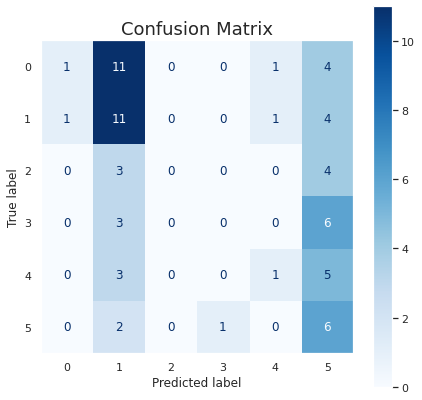

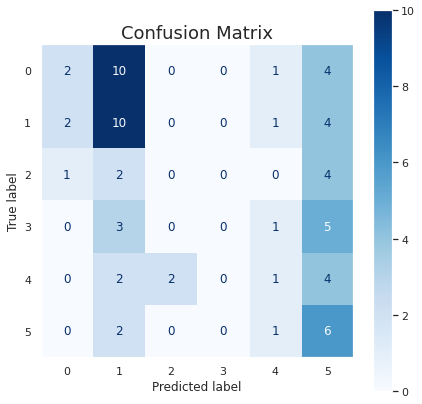

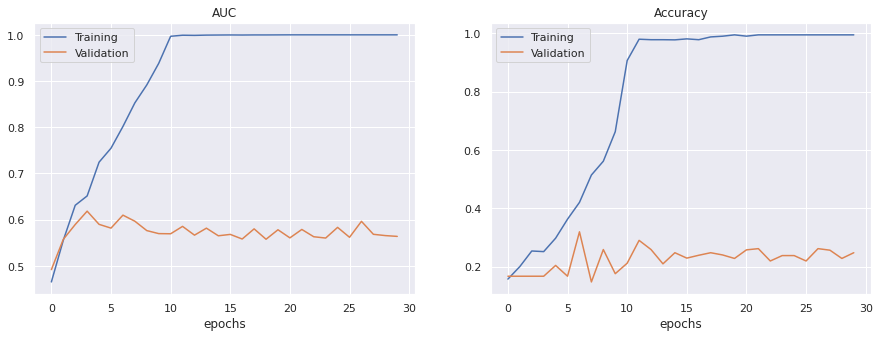

In [ ]:
# Apply MIL ResNet18 without data augmentation
model = MIL_resnet18()

# Define SGD optimizer 
lr=0.001
optimizer = SGD(model.parameters(),lr=lr,momentum=0.8)

# Define CrossEntropy loss function
criterion = nn.CrossEntropyLoss() 

# Define scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 

# ------------------ Freeze only the pre-trained block parameters ------------------ #

for param in model.parameters() :
   param.required_grad = True

for param in list(model.pre_layers1.parameters()):
  param.required_grad = False

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train_MIL(model, epochs, optimizer, scheduler, criterion,train_loader_MIL,val_loader_MIL)

# -------------------- Unfreeze the pre-trained block parameters -------------------- #

for layer in list(model.pre_layers1.children()):
  for param in layer.parameters():
    param.required_grad = True

# Training phase 
train_auc1 , training_loss1 , train_acc1 , val_auc1 , val_acc1 = train_MIL(model, epochs, optimizer, scheduler, criterion, train_loader_MIL,val_loader_MIL, start_epoch=epochs)

# Show training evolution
show(train_auc+train_auc1, val_auc+val_auc1, train_acc+train_acc1, val_acc+val_acc1)

  0%|          | 0/340 [00:00<?, ?it/s]

Train Epoch    Training loss    Training AUC    Training Acc    Validation AUC    Validation Acc
-----------    -------------    ------------    ------------    --------------    ---------------
     1             2.4833          0.5040          0.1829           0.6110            0.2658
     2             1.6354          0.6536          0.3103           0.6596            0.2222
     3             1.4360          0.7575          0.3897           0.6804            0.1863
     4             1.2672          0.8427          0.4860           0.7110            0.2810
     5             0.9036          0.9360          0.7111           0.6303            0.2603
     6             0.5992          0.9704          0.8218           0.6357            0.2558
     7             0.2383          0.9978          0.9436           0.6411            0.1852
     8             0.1031          0.9999          0.9900           0.6850            0.2744
     9             0.0227          1.0000          1.0000    

  0%|          | 0/340 [00:00<?, ?it/s]

    16             1.5200          0.7794          0.4813           0.7852            0.4463
    17             0.8754          0.9165          0.6966           0.7745            0.4244
    18             0.5775          0.9725          0.8186           0.7720            0.4331
    19             0.4036          0.9927          0.9001           0.7788            0.4387
    20             0.2808          0.9982          0.9616           0.7656            0.3884
    21             0.2063          0.9996          0.9752           0.7495            0.4146
    22             0.1958          0.9999          0.9797           0.7495            0.4244
    23             0.1890          0.9999          0.9848           0.7948            0.4289
    24             0.1832          0.9999          0.9898           0.7517            0.3918
    25             0.1779          0.9999          0.9898           0.7867            0.4572
    26             0.1731          0.9999          0.9898           0.

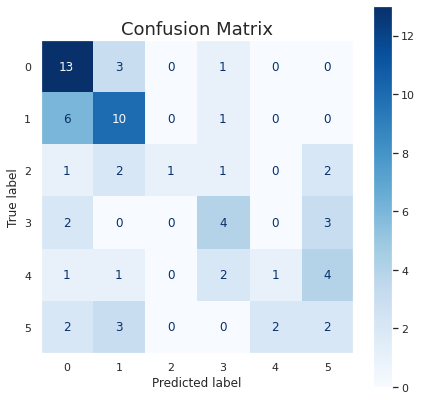

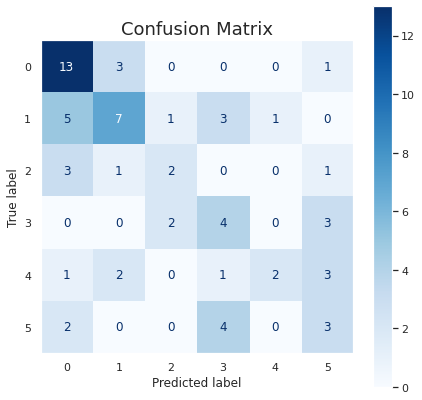

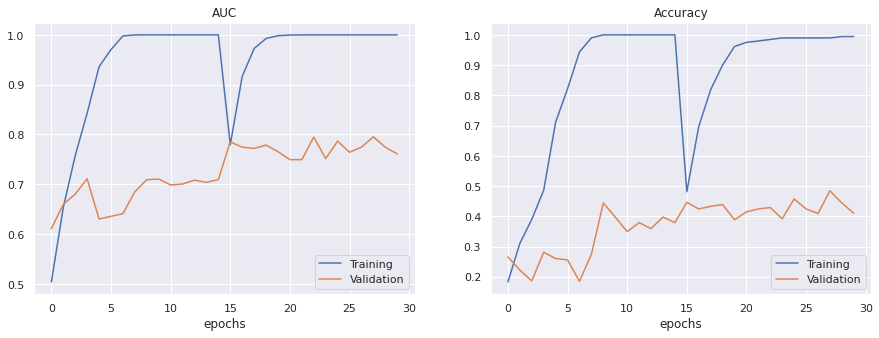

In [ ]:
# Apply MIL ResNet18 with data augmentation
model = MIL_resnet18()

# Define SGD optimizer 
lr=0.001
optimizer = SGD(model.parameters(), lr=lr,momentum=0.8)

# Define CrossEntropy loss function
criterion = nn.CrossEntropyLoss() 

# Define scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 

# ------------------ Freeze only the pre-trained block parameters ------------------ #

for param in model.parameters() :
   param.required_grad = True

for param in list(model.pre_layers1.parameters()):
  param.required_grad = False

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train_MIL_augmented(working_dir, train_df,model, epochs, optimizer, scheduler, criterion)

# -------------------- Unfreeze the pre-trained block parameters -------------------- #

for layer in list(model.pre_layers1.children()):
  for param in layer.parameters():
    param.required_grad = True

# Training phase 
train_auc1 , training_loss1 , train_acc1 , val_auc1 , val_acc1 = train_MIL_augmented(working_dir, train_df,model, epochs, optimizer, scheduler, criterion, start_epoch = epochs )

# Show training evolution
show(train_auc+train_auc1, val_auc+val_auc1, train_acc+train_acc1, val_acc+val_acc1)

##### Training on whole dataset for submission

  0%|          | 0/340 [00:00<?, ?it/s]

Train Epoch    Training loss    Training AUC    Training Acc
-----------    -------------    ------------    ------------
     1             2.2923          0.5162          0.2059
     2             1.6186          0.6533          0.2609
     3             1.4202          0.7656          0.3725
     4             1.2255          0.8371          0.4882
     5             0.9574          0.9079          0.6185
     6             0.6294          0.9632          0.8044
     7             0.3275          0.9947          0.9252
     8             0.1447          0.9988          0.9804
     9             0.0270          1.0000          1.0000
    10             0.0094          1.0000          1.0000
    11             0.0063          1.0000          1.0000
    12             0.0061          1.0000          1.0000
    13             0.0059          1.0000          1.0000
    14             0.0057          1.0000          1.0000
    15             0.0056          1.0000          1.0000


  0%|          | 0/340 [00:00<?, ?it/s]

    16             1.3982          0.8102          0.5221
    17             0.7198          0.9461          0.7308
    18             0.4751          0.9827          0.8737
    19             0.3160          0.9967          0.9346
    20             0.2229          0.9997          0.9752
    21             0.1537          1.0000          1.0000
    22             0.1489          1.0000          0.9963
    23             0.1449          1.0000          0.9963
    24             0.1409          1.0000          0.9963
    25             0.1372          1.0000          1.0000
    26             0.1336          1.0000          0.9963
    27             0.1302          1.0000          1.0000
    28             0.1270          1.0000          1.0000
    29             0.1238          1.0000          1.0000
    30             0.1209          1.0000          1.0000


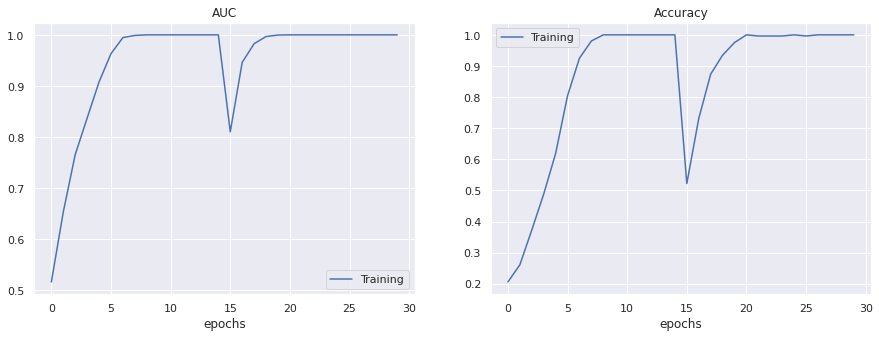

In [ ]:
# Apply MIL ResNet18 with data augmentation on whole data
model = MIL_resnet18()

# Define SGD optimizer 
lr=0.001
optimizer = SGD(model.parameters(), lr=lr,momentum=0.8)

# Define CrossEntropy loss function
criterion = nn.CrossEntropyLoss() 

# Define scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 

# ------------------ Freeze only the pre-trained block parameters ------------------ #

for param in model.parameters() :
   param.required_grad = True

for param in list(model.pre_layers1.parameters()):
  param.required_grad = False

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train_MIL_augmented(working_dir, train_df,model, epochs, optimizer, scheduler, criterion,val=False)

# -------------------- Unfreeze the pre-trained block parameters -------------------- #

for layer in list(model.pre_layers1.children()):
  for param in layer.parameters():
    param.required_grad = True

# Training phase 
train_auc1 , training_loss1 , train_acc1 , val_auc1 , val_acc1 = train_MIL_augmented(working_dir, train_df,model, epochs, optimizer, scheduler, criterion, start_epoch = epochs, val=False)

# Show training evolution
show(train_auc+train_auc1, val_auc+val_auc1, train_acc+train_acc1, val_acc+val_acc1)

#### Semi-supervised MIL ResNet18

In [ ]:
# Read the unlabeled data for MIL model
X_unlabled = read_data_MIL(working_dir+'Unlabeled_data/all_tiles_normalized', train_df, augmented=False, labeled=False)

epochs = 8
batch_size = 1

# Loop until chosen number of added samples
while len(y) < 500 :

  # Define loader for labeled data
  trainset = torch.utils.data.TensorDataset(torch.tensor(X).float(), torch.tensor(y))
  train_labled_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)  

  # Define loader for unlabeled data
  trainset_unlabled = torch.utils.data.TensorDataset(torch.tensor(X_unlabled).float(),torch.from_numpy(np.zeros(len(X_unlabled))))
  train_unlabled_loader = torch.utils.data.DataLoader(trainset_unlabled, batch_size=batch_size, shuffle=True)

  # Define model
  model = MIL_resnet18() 

  # Define loss function
  criterion = torch.nn.CrossEntropyLoss()

  # Define optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

  # Define scheduler
  scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 
 
 # ------------------ Freeze only pre-trained block parameters ------------------ #

  for param in model.parameters() :
    param.required_grad = True

  for param in list(model.pre_layers1.parameters()):
    param.required_grad = False

  # Training phase 
  train_auc , training_loss , train_acc , val_auc , val_acc = train_MIL(model,epochs,optimizer, scheduler, criterion,train_loader_MIL, val_loader_MIL, start_epoch = 0, show=False)

  # -------------------- Unfreeze pre-trained block parameters -------------------- #
  for layer in list(model.pre_layers1.children()):
    for param in layer.parameters():
      param.required_grad = True
  
  # Training phase 
  train_auc , training_loss , train_acc , val_auc , val_acc = train_MIL(model,epochs,optimizer, scheduler, criterion,train_loader_MIL, val_loader_MIL,  start_epoch = epochs,show=False)

  # ----------------------- Create new labels ---------------------------- #
  model.eval()
  with torch.no_grad():

    keep_idx = []
    new_lables = []

    # Loop over unlabeled data
    for batch_idx, (data, target) in enumerate(train_unlabled_loader):
        data, target = data.to(device), target.to(device)

        # Apply model
        output = model(data)

        # Compute probability output
        predicted_batch = F.softmax(output,dim=1)

        # Compute labels
        labels =  torch.argmax(predicted_batch,dim=1).cpu().detach().numpy()

        # Select only samples with confidence > 0.75
        predicted = torch.max(predicted_batch,dim=1).values.cpu().numpy() >= 0.75
        idx = np.where(predicted==True)[0]
        new_lables += list(labels[idx])
        keep_idx = keep_idx + list(idx + batch_idx * 1)

  if len (new_lables) != 0 :
    remaining = list(set(np.arange(len(X_unlabled))) - set(keep_idx))

    # Update labeled data and corresponding labels
    X = np.r_[X,X_unlabled[keep_idx]] 
    y = np.array(list(y) + new_lables) 

    # Update unlabeled data
    X_unlabled = X_unlabled[remaining]

    print('Number of total labled samples:', len(y))
  else :
    print('No samples added')

# ----------------------- Last train ---------------------------- # 

# Selecting labled and last pseudo labeled samples 
trainset = torch.utils.data.TensorDataset(torch.tensor(X).float(), torch.tensor(y))
train_labled_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Define model
model = MIL_resnet18() 

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Define schedular
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 

# ------------------ Freeze only pre-trained block parameters ------------------ #

for param in model.parameters() :
  param.required_grad = True

for param in list(model.pre_layers1.parameters()):
  param.required_grad = False

# Training phase 
train_auc , training_loss , train_acc , val_auc , val_acc = train_MIL(model,epochs,optimizer, scheduler, criterion,train_loader_MIL, val_loader_MIL, start_epoch = 0,show=False)

# -------------------- Unfreeze pre-trained block parameters -------------------- #

for layer in list(model.pre_layers1.children()):
  for param in layer.parameters():
    param.required_grad = True

# Training phase
train_auc , training_loss , train_acc , val_auc , val_acc = train_MIL(model,epochs,optimizer, scheduler, criterion,train_loader_MIL, val_loader_MIL, start_epoch = epochs,show=False)

  0%|          | 0/387 [00:00<?, ?it/s]

Train Epoch    Training loss    Training AUC    Training Acc    Validation AUC    Validation Acc
-----------    -------------    ------------    ------------    --------------    ---------------
     1             2.1165          0.4623          0.1364           0.5696            0.2089
     2             1.8401          0.5899          0.2368           0.5678            0.1667
     3             1.6960          0.6380          0.2534           0.6084            0.2298
     4             1.6223          0.6608          0.2796           0.5803            0.1667
     5             1.4782          0.7221          0.3149           0.5552            0.1667
     6             1.4165          0.7462          0.3518           0.5960            0.1667
     7             1.3283          0.7907          0.4115           0.6267            0.2549
     8             1.2017          0.8418          0.4805           0.6160            0.1993
     9             1.0675          0.8821          0.5498    

## Testing

In [ ]:
# Create tiles for test data
"""
_ = create_tiles(path_images=path_test_images, path_to_save=working_dir+'test_clean_normalized/', n=n)
concatenate_tiles(working_dir+'test_clean_normalized/',working_dir+'test_clean_n_concatenated/')
"""

  0%|          | 0/86 [00:00<?, ?it/s]

## Read test data for ResNet18 & Pooling-ResNet18

In [ ]:
X_test, test_Id = read_test_data(working_dir + 'test_clean_n_concatenated/')

  0%|          | 0/86 [00:00<?, ?it/s]

## Read test data for MIL-ResNet18

In [ ]:
X_test , test_Id = read_test_data_MIL(working_dir + 'test_clean_normalized/')

  0%|          | 0/1720 [00:00<?, ?it/s]

## Create submission file

In [ ]:
# Retrieve test images Ids
test_id = test_df['image_id'].tolist()

# Define test loader
test_loader = torch.utils.data.DataLoader(torch.tensor(X_test).float(), shuffle=False)
y_test = []

model.eval()

with torch.no_grad():
  # Loop over test images
  for batch_idx, data in enumerate(test_loader):

    data= data.to(device)

    # Apply model
    output = model(data)

    # Compute label
    predicted_batch = output.argmax(dim=1).cpu().numpy()[0]
    y_test.append(predicted_batch)

test_Id = np.asarray(test_Id)

# List of labels of all test images
y_test = [y_test[list(test_Id).index(i)] for i in list(test_id)]

# Create submission file
sub = pd.DataFrame({'Id': test_id, 'Predicted': y_test})
sub.to_csv('submission.csv', index=False)